In [1]:
import requests
import json
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from scipy.stats import stats

import time

# Games Data

## Creating function to request data 

In [2]:
def get_games_data(page=1, per_page=100, total_pages=None):
    
    # Get number of pages
    url = 'https://www.balldontlie.io/api/v1/games'
    parameters = {'per_page': per_page, 'page': page}
    
    
    resp = requests.get(url, params=parameters).json()
    total_pages = min(x for x in [resp['meta']['total_pages'], total_pages] if x is not None)
    
    # Initialize data frame
    games_data = pd.DataFrame()
        
    for page_num in range(page, total_pages+1):
                
        # Make request
        parameters = {'page': page_num, 'per_page': per_page}
        
        resp = requests.get(url, params=parameters).json()
        
        # Create dataframe from json data key
        data = pd.DataFrame.from_records(resp['data'])    
        
        # Format date column to date column
        data['date'] = pd.to_datetime(data['date'], yearfirst=True, errors='coerce').dt.tz_localize(None)
        
        # Creating columns out of the dictionary-type columns
        for col in data.columns:
            if type(data[col][0]) == dict:
                for k in data[col][0].keys():
                    data[col+"_"+k] = data[col].apply(lambda x: x[k])
                    
        # Create a page column
        data['page'] = page_num
        
        # Concat data frames
        games_data = pd.concat([games_data, data])
        
        # Delay next request
        time.sleep(.8)
    
    
    return games_data
    

In [3]:
games_data = get_games_data()

In [4]:
games_data.to_csv('games_data.csv', index=False)

In [3]:
games_data = pd.read_csv('games_data.csv')

In [8]:
games_data.head()

,date,home_team,home_team_score,id,period,postseason,season,status,time,visitor_team,...,home_team_full_name,home_team_name,visitor_team_id,visitor_team_abbreviation,visitor_team_city,visitor_team_conference,visitor_team_division,visitor_team_full_name,visitor_team_name,page
0,2019-01-30,"{'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...",126,47179,4,False,2018,Final,,"{'id': 4, 'abbreviation': 'CHA', 'city': 'Char...",...,Boston Celtics,Celtics,4,CHA,Charlotte,East,Southeast,Charlotte Hornets,Hornets,1
1,2019-02-09,"{'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...",112,48751,4,False,2018,Final,,"{'id': 13, 'abbreviation': 'LAC', 'city': 'LA'...",...,Boston Celtics,Celtics,13,LAC,LA,West,Pacific,LA Clippers,Clippers,1
2,2019-02-08,"{'id': 23, 'abbreviation': 'PHI', 'city': 'Phi...",117,48739,4,False,2018,Final,,"{'id': 8, 'abbreviation': 'DEN', 'city': 'Denv...",...,Philadelphia 76ers,76ers,8,DEN,Denver,West,Northwest,Denver Nuggets,Nuggets,1
3,2019-02-08,"{'id': 30, 'abbreviation': 'WAS', 'city': 'Was...",119,48740,4,False,2018,Final,,"{'id': 6, 'abbreviation': 'CLE', 'city': 'Clev...",...,Washington Wizards,Wizards,6,CLE,Cleveland,East,Central,Cleveland Cavaliers,Cavaliers,1
4,2019-02-08,"{'id': 26, 'abbreviation': 'SAC', 'city': 'Sac...",102,48746,4,False,2018,Final,,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",...,Sacramento Kings,Kings,16,MIA,Miami,East,Southeast,Miami Heat,Heat,1


# Hypothesis 1: West_Score = B0 + B1 East_Score

## Creating function to shape dataframe

id, East Score, West Score

In [31]:
games_data.head()

,date,home_team,home_team_score,id,period,postseason,season,status,time,visitor_team,...,visitor_team_conference,visitor_team_division,visitor_team_full_name,visitor_team_name,page,east_team,east_score,west_team,west_score,west_minus_east
0,2019-01-30,"{'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...",126,47179,4,False,2018,Final,,"{'id': 4, 'abbreviation': 'CHA', 'city': 'Char...",...,East,Southeast,Charlotte Hornets,Hornets,1,Boston Celtics,126,Charlotte Hornets,94,-32
1,2019-02-09,"{'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...",112,48751,4,False,2018,Final,,"{'id': 13, 'abbreviation': 'LAC', 'city': 'LA'...",...,West,Pacific,LA Clippers,Clippers,1,Boston Celtics,112,LA Clippers,123,11
2,2019-02-08,"{'id': 23, 'abbreviation': 'PHI', 'city': 'Phi...",117,48739,4,False,2018,Final,,"{'id': 8, 'abbreviation': 'DEN', 'city': 'Denv...",...,West,Northwest,Denver Nuggets,Nuggets,1,Philadelphia 76ers,117,Denver Nuggets,110,-7
3,2019-02-08,"{'id': 30, 'abbreviation': 'WAS', 'city': 'Was...",119,48740,4,False,2018,Final,,"{'id': 6, 'abbreviation': 'CLE', 'city': 'Clev...",...,East,Central,Cleveland Cavaliers,Cavaliers,1,Washington Wizards,119,Cleveland Cavaliers,106,-13
4,2019-02-08,"{'id': 26, 'abbreviation': 'SAC', 'city': 'Sac...",102,48746,4,False,2018,Final,,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",...,East,Southeast,Miami Heat,Heat,1,Miami Heat,96,Sacramento Kings,102,6


In [47]:
def games_data_east_west(data):
    
    # Filter to only include games where East plays West team
    data = data.loc[((data['home_team_conference']=="East")&(data['visitor_team_conference']=="West")) 
                    | ((data['home_team_conference']=="West")&(data['visitor_team_conference']=="East"))]

    # Creating East columns
    data['east_team'] = np.where(data['home_team_conference']=="East", data['home_team_full_name'], data['visitor_team_full_name'])
    data['east_score'] = np.where(data['home_team_conference']=="East", data['home_team_score'], data['visitor_team_score'])
    
    # Creating West columns
    data['west_team'] = np.where(data['home_team_conference']=="West", data['home_team_full_name'], data['visitor_team_full_name'])
    data['west_score'] = np.where(data['home_team_conference']=="West", data['home_team_score'], data['visitor_team_score'])
    
    
    data['west_minus_east'] = data['west_score'] - data['east_score']
    data['division_winner'] = np.where(data['west_score']>data['east_score'],"West","East")
    
    data = data[['id', 'date', 'season', 'east_team', 'east_score', 'west_team', 'west_score', 'west_minus_east', 'division_winner']]
    return data

In [48]:
games_data_east_west = games_data_east_west(games_data)

C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [49]:
games_data_east_west.head()

,id,date,season,east_team,east_score,west_team,west_score,west_minus_east,division_winner
1,48751,2019-02-09,2018,Boston Celtics,112,LA Clippers,123,11,West
2,48739,2019-02-08,2018,Philadelphia 76ers,117,Denver Nuggets,110,-7,East
4,48746,2019-02-08,2018,Miami Heat,96,Sacramento Kings,102,6,West
12,48760,2019-02-10,2018,Philadelphia 76ers,143,Los Angeles Lakers,120,-23,East
16,48759,2019-02-10,2018,Miami Heat,118,Golden State Warriors,120,2,West


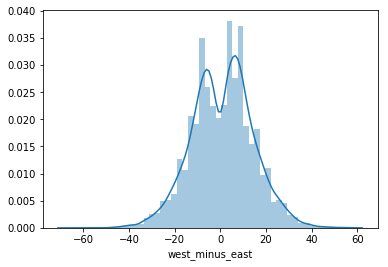

In [42]:
sns.distplot(games_data_east_west['west_minus_east']);

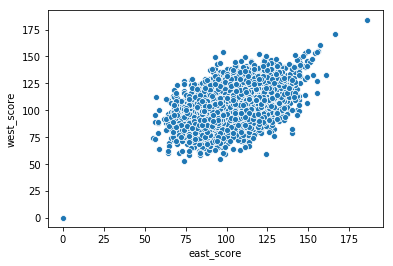

In [50]:
sns.scatterplot(data=games_data_east_west, x='east_score', y='west_score');

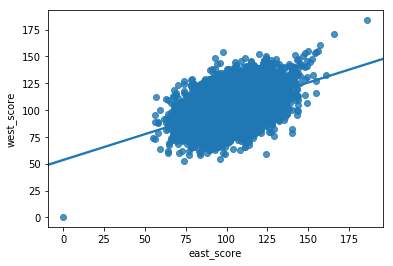

In [51]:
sns.regplot(data=games_data_east_west, x='east_score', y='west_score');

## Create regression function

In [200]:
X = games_data_reshaped['east_score']
y = games_data_reshaped['west_score']
X = sm.add_constant(X)
mod = sm.OLS(y, X, hasconst= True)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             west_score   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     4679.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:56:11   Log-Likelihood:                -59626.
No. Observations:               15403   AIC:                         1.193e+05
Df Residuals:                   15401   BIC:                         1.193e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.4712      0.720     74.277      0.0

# Hypothesis 2: No Team has Better Home Court Advantage

In [67]:
def games_data_home(data):
    
    data['home_win'] = (data['home_team_score'] > data['visitor_team_score'])*1
    
    data['home_score_diff'] = data['home_team_score'] - data['visitor_team_score']
    
    data = data[['id', 'home_team_full_name', 'home_team_score', 'home_score_diff', 'home_win']]
    return data

In [68]:
games_data_home = games_data_home(games_data)

In [69]:
games_data_home.head()

,id,home_team_full_name,home_team_score,home_score_diff,home_win
0,47179,Boston Celtics,126,32,1
1,48751,Boston Celtics,112,-11,0
2,48739,Philadelphia 76ers,117,7,1
3,48740,Washington Wizards,119,13,1
4,48746,Sacramento Kings,102,6,1
